In [1]:
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets

def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(chain.from_iterable(
        [target_idx[idx][:max_len] for idx in range(len(classes))]
    ))

    return Subset(dataset, indices)

train_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = True)
test_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = True)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(classes)
print(class_to_idx)

subset_train_dataset = subset_sampler(dataset = train_dataset, classes = train_dataset.classes, max_len = 1000)
subset_test_dataset = subset_sampler(dataset = test_dataset, classes = test_dataset.classes, max_len = 100)

print(f"Training Data Size: {len(subset_train_dataset)}")
print(f"Testing Data Size: {len(subset_test_dataset)}")

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Training Data Size: 10000
Testing Data Size: 1000


In [2]:
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (image_processor.size["height"], image_processor.size["width"])),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
])

print(f"size: {image_processor.size}")
print(f"mean: {image_processor.image_mean}")
print(f"std: {image_processor.image_std}")

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


size: {'height': 224, 'width': 224}
mean: [0.5, 0.5, 0.5]
std: [0.5, 0.5, 0.5]


In [3]:
from torch.utils.data import DataLoader

def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])

    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(subset_train_dataset, batch_size = 32, shuffle = True, collate_fn = lambda x: collator(x, transform), drop_last = True)
valid_dataloader = DataLoader(subset_test_dataset, batch_size = 4, shuffle = True, collate_fn = lambda x: collator(x, transform), drop_last = True)

batch = next(iter(train_dataloader))

for key, value in batch.items():
    print(f"{key}: {value.shape}")

pixel_values: torch.Size([32, 3, 224, 224])
labels: torch.Size([32])


In [4]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    num_labels = len(classes),
    id2label = {idx: label for label, idx in class_to_idx.items()},
    label2id = class_to_idx,
    ignore_mismatched_sizes = True
)

print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [5]:
print(model.vit.embeddings)

batch = next(iter(train_dataloader))
print("image shape:", batch["pixel_values"].shape)
print("patch embeddings shape: ", model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape)

ViTEmbeddings(
  (patch_embeddings): ViTPatchEmbeddings(
    (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
image shape: torch.Size([32, 3, 224, 224])
patch embeddings shape:  torch.Size([32, 196, 768])


In [39]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir = "models/ViT-FashionMNIST",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.001,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    logging_dir = "logs",
    logging_steps = 125,
    remove_unused_columns = False,
    seed = 7
)

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
    metirc = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    macro_f1 = metirc.compute(predictions = predictions, references = labels, average = "macro")

    return macro_f1

In [8]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer

def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)

    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(chain.from_iterable([target_idx[idx][ : max_len] for idx in range(len(classes))]))

    return Subset(dataset, indices)

def model_init(classes, class_to_idx):
    model = ViTForImageClassification.from_pretrained(
        pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
        num_labels = len(classes),
        id2label = {idx: label for label, idx in class_to_idx.items()},
        label2id = class_to_idx,
    )

    return model

def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])

    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    macro_f1 = metric.compute(predictions = predictions, references = labels, average = "macro")

    return macro_f1

train_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = True)
test_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(dataset = train_dataset, classes = train_dataset.classes, max_len = 1000)
subset_test_dataset = subset_sampler(dataset = test_dataset, classes = test_dataset.classes, max_len = 100)

image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (image_processor.size["height"], image_processor.size["width"])),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
])

args = TrainingArguments(
    output_dir = "models/ViT-FashionMNIST",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.001,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    logging_dir = "logs",
    logging_steps = 125,
    remove_unused_columns = False,
    seed = 7
)

trainer = Trainer(
    model_init = lambda x: model_init(classes, class_to_idx),
    args = args,
    train_dataset = subset_train_dataset,
    eval_dataset = subset_test_dataset,
    data_collator = lambda x:collator(x, transform),
    compute_metrics = compute_metrics,
    tokenizer = image_processor
)

trainer.train()

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights 

{'loss': 1.9237, 'grad_norm': 2.6046998500823975, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.2}


 13%|█▎        | 250/1875 [01:51<11:20,  2.39it/s]

{'loss': 1.2702, 'grad_norm': 3.7780303955078125, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}


 20%|██        | 375/1875 [02:45<10:34,  2.36it/s]

{'loss': 0.9321, 'grad_norm': 1.7168519496917725, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.6}


 27%|██▋       | 500/1875 [03:41<09:43,  2.36it/s]

{'loss': 0.7969, 'grad_norm': 1.9505627155303955, 'learning_rate': 7.333333333333333e-06, 'epoch': 0.8}


 33%|███▎      | 625/1875 [04:36<08:43,  2.39it/s]

{'loss': 0.6995, 'grad_norm': 5.6881818771362305, 'learning_rate': 6.666666666666667e-06, 'epoch': 1.0}


                                                  
 33%|███▎      | 625/1875 [04:48<08:43,  2.39it/s]

{'eval_loss': 0.6316495537757874, 'eval_f1': 0.8797428763117692, 'eval_runtime': 11.8357, 'eval_samples_per_second': 84.49, 'eval_steps_per_second': 5.323, 'epoch': 1.0}


 40%|████      | 750/1875 [05:43<09:16,  2.02it/s]  

{'loss': 0.6189, 'grad_norm': 3.0232386589050293, 'learning_rate': 6e-06, 'epoch': 1.2}


 47%|████▋     | 875/1875 [06:36<07:03,  2.36it/s]

{'loss': 0.5674, 'grad_norm': 2.897817611694336, 'learning_rate': 5.333333333333334e-06, 'epoch': 1.4}


 53%|█████▎    | 1000/1875 [07:31<07:33,  1.93it/s]

{'loss': 0.5319, 'grad_norm': 2.749706506729126, 'learning_rate': 4.666666666666667e-06, 'epoch': 1.6}


 60%|██████    | 1125/1875 [08:24<05:08,  2.43it/s]

{'loss': 0.5046, 'grad_norm': 2.690584182739258, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.8}


 67%|██████▋   | 1250/1875 [09:18<04:25,  2.35it/s]

{'loss': 0.4764, 'grad_norm': 2.5242724418640137, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 1250/1875 [09:30<04:25,  2.35it/s]

{'eval_loss': 0.47042492032051086, 'eval_f1': 0.9081810220097433, 'eval_runtime': 11.921, 'eval_samples_per_second': 83.885, 'eval_steps_per_second': 5.285, 'epoch': 2.0}


 73%|███████▎  | 1375/1875 [10:24<03:23,  2.46it/s]

{'loss': 0.4579, 'grad_norm': 3.3208765983581543, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.2}


 80%|████████  | 1500/1875 [11:18<02:32,  2.46it/s]

{'loss': 0.4251, 'grad_norm': 8.31917953491211, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}


 87%|████████▋ | 1625/1875 [12:09<01:40,  2.48it/s]

{'loss': 0.4121, 'grad_norm': 1.79793381690979, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.6}


 93%|█████████▎| 1750/1875 [13:01<00:50,  2.47it/s]

{'loss': 0.4161, 'grad_norm': 4.276185512542725, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.8}


100%|██████████| 1875/1875 [13:51<00:00,  2.49it/s]

{'loss': 0.417, 'grad_norm': 3.3328895568847656, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 1875/1875 [14:03<00:00,  2.49it/s]

{'eval_loss': 0.42596685886383057, 'eval_f1': 0.9201352774781413, 'eval_runtime': 11.0405, 'eval_samples_per_second': 90.576, 'eval_steps_per_second': 5.706, 'epoch': 3.0}


100%|██████████| 1875/1875 [14:04<00:00,  2.22it/s]

{'train_runtime': 844.3866, 'train_samples_per_second': 35.529, 'train_steps_per_second': 2.221, 'train_loss': 0.6966573567708333, 'epoch': 3.0}


TrainOutput(global_step=1875, training_loss=0.6966573567708333, metrics={'train_runtime': 844.3866, 'train_samples_per_second': 35.529, 'train_steps_per_second': 2.221, 'total_flos': 2.32492637712384e+18, 'train_loss': 0.6966573567708333, 'epoch': 3.0})

100%|██████████| 63/63 [00:12<00:00,  4.96it/s]


PredictionOutput(predictions=array([[ 3.0747428 , -0.6475201 , -0.31349835, ..., -0.57506925,
        -0.32783478, -0.59344864],
       [ 1.9908917 , -0.67991227, -0.2870769 , ..., -0.8056709 ,
        -0.8114096 , -0.97272813],
       [ 2.9991624 , -0.61407155, -0.18053368, ..., -0.53670514,
        -0.3851152 , -0.60585666],
       ...,
       [-0.5819899 , -0.5872841 , -0.56017524, ...,  0.5857005 ,
         0.39734906,  3.002391  ],
       [-0.5652046 , -0.370638  , -0.3114145 , ...,  0.11991591,
        -0.29912308,  3.4034278 ],
       [-0.5331673 , -0.33400452, -0.2935348 , ..., -0.27478296,
        -0.15160224,  3.4188042 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

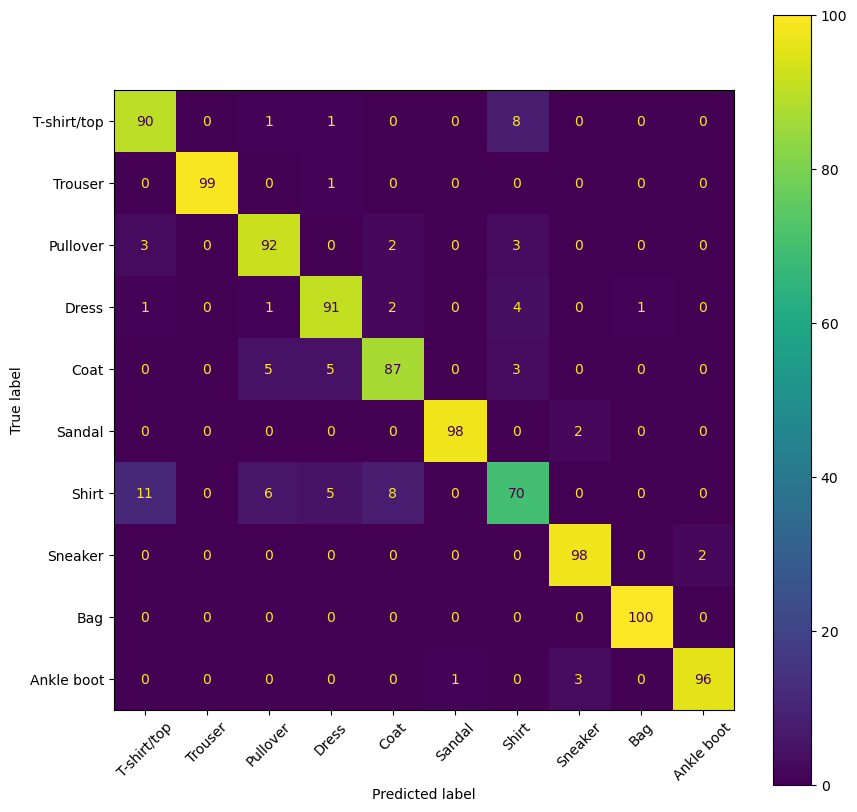

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

label = list(classes)
matrix = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)
_, ax = plt.subplots(figsize = (10, 10))
display.plot(xticks_rotation = 45, ax = ax)
plt.show()

In [10]:
import torch

window_size = 2
coords_h = torch.arange(window_size)
coords_w = torch.arange(window_size)
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing = "ij"))
coords_flatten = torch.flatten(coords, 1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

print(relative_coords)
print(relative_coords.shape)

tensor([[[ 0,  0, -1, -1],
         [ 0,  0, -1, -1],
         [ 1,  1,  0,  0],
         [ 1,  1,  0,  0]],

        [[ 0, -1,  0, -1],
         [ 1,  0,  1,  0],
         [ 0, -1,  0, -1],
         [ 1,  0,  1,  0]]])
torch.Size([2, 4, 4])


In [11]:
x_coords = relative_coords[0, : , : ]
y_coords = relative_coords[1, : , : ]

x_coords += window_size - 1
y_coords += window_size - 1
x_coords *= 2 * window_size - 1

print(f"X축에 대한 행렬: \n{x_coords}\n")
print(f"Y축에 대한 행렬: \n{y_coords}\n")

relative_posision_index = x_coords + y_coords

print(f"X, Y축에 대한 위치 행렬: \n{relative_posision_index}")

X축에 대한 행렬: 
tensor([[3, 3, 0, 0],
        [3, 3, 0, 0],
        [6, 6, 3, 3],
        [6, 6, 3, 3]])

Y축에 대한 행렬: 
tensor([[1, 0, 1, 0],
        [2, 1, 2, 1],
        [1, 0, 1, 0],
        [2, 1, 2, 1]])

X, Y축에 대한 위치 행렬: 
tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])


In [12]:
num_heads = 1

relative_posision_bias_table = torch.Tensor(torch.zeros((2 * window_size - 1) * (2 * window_size -1), num_heads))
relative_posision_bias = relative_posision_bias_table[relative_posision_index.view(-1)]
relative_posision_bias = relative_posision_bias.view(window_size * window_size, window_size * window_size, -1)

print(relative_posision_bias.shape)

torch.Size([4, 4, 1])


In [13]:
from transformers import SwinForImageClassification

model = SwinForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
    num_labels = len(train_dataset.classes),
    id2label = {idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id = train_dataset.class_to_idx,
    ignore_mismatched_sizes = True
)

for main_name, main_module in model.named_children():
    print(main_name)

    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)

        for ssub_name, ssub_module in sub_module.named_children():
            print("|    └", ssub_module)

            for sssub_name, sssub_module in ssub_module.named_children():

                if sssub_name == "projection":
                    print("|    |   └", ssub_name, sssub_module)
                else:
                    print("|    |   └")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


swin
└ embeddings
|    └ SwinPatchEmbeddings(
  (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
)
|    |   └ patch_embeddings Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
|    └ LayerNorm((96,), eps=1e-05, elementwise_affine=True)
|    └ Dropout(p=0.0, inplace=False)
└ encoder
|    └ ModuleList(
  (0): SwinStage(
    (blocks): ModuleList(
      (0-1): 2 x SwinLayer(
        (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attention): SwinAttention(
          (self): SwinSelfAttention(
            (query): Linear(in_features=96, out_features=96, bias=True)
            (key): Linear(in_features=96, out_features=96, bias=True)
            (value): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): SwinSelfOutput(
            (dense): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
      

In [14]:
batch = next(iter(train_dataloader))
print("이미지 차원: ", batch["pixel_values"].shape)

patch_emb_output, shape = model.swin.embeddings.patch_embeddings(batch["pixel_values"])

print("모듈: ", model.swin.embeddings.patch_embeddings)
print("패치 임베딩 차원: ", patch_emb_output.shape)

이미지 차원:  torch.Size([32, 3, 224, 224])
모듈:  SwinPatchEmbeddings(
  (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
)
패치 임베딩 차원:  torch.Size([32, 3136, 96])


In [15]:
for main_name, main_module in model.swin.encoder.layers[0].named_children():
    print(main_name)

    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)

        for ssub_name, ssub_module in sub_module.named_children():
            print("|    └", ssub_name)

blocks
└ 0
|    └ layernorm_before
|    └ attention
|    └ drop_path
|    └ layernorm_after
|    └ intermediate
|    └ output
└ 1
|    └ layernorm_before
|    └ attention
|    └ drop_path
|    └ layernorm_after
|    └ intermediate
|    └ output
downsample
└ reduction
└ norm


In [16]:
print(model.swin.encoder.layers[0].blocks[0])

SwinLayer(
  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (attention): SwinAttention(
    (self): SwinSelfAttention(
      (query): Linear(in_features=96, out_features=96, bias=True)
      (key): Linear(in_features=96, out_features=96, bias=True)
      (value): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=96, out_features=96, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (drop_path): SwinDropPath(p=0.1)
  (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=96, out_features=384, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=384, out_features=96, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)


In [17]:
print("패치 이베딩 차원: ", patch_emb_output.shape)

W_MSA = model.swin.encoder.layers[0].blocks[0]
SW_MSA = model.swin.encoder.layers[0].blocks[1]

W_MSA_output = W_MSA(patch_emb_output, W_MSA.input_resolution)[0]
SW_MSA_output = SW_MSA(W_MSA_output, SW_MSA.input_resolution)[0]

print("W-MSA 결과 차원: ", W_MSA_output.shape)
print("SW-MSA 겨로가 차원: ", SW_MSA_output.shape)

패치 이베딩 차원:  torch.Size([32, 3136, 96])
W-MSA 결과 차원:  torch.Size([32, 3136, 96])
SW-MSA 겨로가 차원:  torch.Size([32, 3136, 96])


In [18]:
patch_merge = model.swin.encoder.layers[0].downsample
print("patch_merge 모듈 :", patch_merge)

output = patch_merge(SW_MSA_output, patch_merge.input_resolution)
print("patch_merge 결과 차원 :", output.shape)

patch_merge 모듈 : SwinPatchMerging(
  (reduction): Linear(in_features=384, out_features=192, bias=False)
  (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
)
patch_merge 결과 차원 : torch.Size([32, 784, 192])


In [19]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import SwinForImageClassification
from transformers import TrainingArguments, Trainer

def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)

    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        ))

    return Subset(dataset, indices)


def model_init(classes, class_to_idx):

    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path = "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )

    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])

    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    return macro_f1


train_dataset = datasets.FashionMNIST(root="datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(dataset = train_dataset, classes = train_dataset.classes, max_len = 1000)
subset_test_dataset = subset_sampler(dataset = test_dataset, classes = test_dataset.classes, max_len = 100)

image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size = (image_processor.size["height"], image_processor.size["width"])),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        transforms.Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
    ])

args = TrainingArguments(
    output_dir = "models/Swin-FashionMNIST",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.001,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    logging_dir = "logs",
    logging_steps = 125,
    remove_unused_columns = False,
    seed = 7
)

trainer = Trainer(
    model_init = lambda x: model_init(classes, class_to_idx),
    args = args,
    train_dataset = subset_train_dataset,
    eval_dataset = subset_test_dataset,
    data_collator = lambda x: collator(x, transform),
    compute_metrics = compute_metrics,
    tokenizer = image_processor,
)

trainer.train()

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some

{'loss': 1.2401, 'grad_norm': 68.71468353271484, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.2}


 13%|█▎        | 250/1875 [00:52<05:36,  4.83it/s]

{'loss': 0.5527, 'grad_norm': 28.945125579833984, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}


 20%|██        | 375/1875 [01:18<05:06,  4.89it/s]

{'loss': 0.4125, 'grad_norm': 30.033754348754883, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.6}


 27%|██▋       | 500/1875 [01:45<04:42,  4.87it/s]

{'loss': 0.4079, 'grad_norm': 18.297677993774414, 'learning_rate': 7.333333333333333e-06, 'epoch': 0.8}


 33%|███▎      | 625/1875 [02:10<04:17,  4.86it/s]

{'loss': 0.3595, 'grad_norm': 45.46546936035156, 'learning_rate': 6.666666666666667e-06, 'epoch': 1.0}



 33%|███▎      | 625/1875 [02:16<04:17,  4.86it/s]

{'eval_loss': 0.3191010057926178, 'eval_f1': 0.8883462742987298, 'eval_runtime': 6.1988, 'eval_samples_per_second': 161.321, 'eval_steps_per_second': 10.163, 'epoch': 1.0}


 40%|████      | 750/1875 [02:42<03:49,  4.91it/s]

{'loss': 0.3171, 'grad_norm': 32.27617263793945, 'learning_rate': 6e-06, 'epoch': 1.2}


 47%|████▋     | 875/1875 [03:10<03:26,  4.84it/s]

{'loss': 0.3139, 'grad_norm': 26.98628807067871, 'learning_rate': 5.333333333333334e-06, 'epoch': 1.4}


 53%|█████▎    | 1000/1875 [03:36<03:04,  4.75it/s]

{'loss': 0.3186, 'grad_norm': 5.835513591766357, 'learning_rate': 4.666666666666667e-06, 'epoch': 1.6}


 60%|██████    | 1125/1875 [04:03<02:37,  4.78it/s]

{'loss': 0.2817, 'grad_norm': 8.690406799316406, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.8}


 67%|██████▋   | 1250/1875 [04:30<02:06,  4.94it/s]

{'loss': 0.2699, 'grad_norm': 13.222615242004395, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}



 67%|██████▋   | 1250/1875 [04:36<02:06,  4.94it/s]

{'eval_loss': 0.2720056474208832, 'eval_f1': 0.9088339761786663, 'eval_runtime': 6.1393, 'eval_samples_per_second': 162.885, 'eval_steps_per_second': 10.262, 'epoch': 2.0}


 73%|███████▎  | 1376/1875 [05:02<01:43,  4.82it/s]

{'loss': 0.2619, 'grad_norm': 13.100768089294434, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.2}


 80%|████████  | 1501/1875 [05:28<01:16,  4.89it/s]

{'loss': 0.2328, 'grad_norm': 25.81658172607422, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}


 87%|████████▋ | 1626/1875 [05:54<00:50,  4.89it/s]

{'loss': 0.2262, 'grad_norm': 11.041215896606445, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.6}


 93%|█████████▎| 1751/1875 [06:21<00:26,  4.67it/s]

{'loss': 0.247, 'grad_norm': 23.8407039642334, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.8}


100%|██████████| 1875/1875 [06:47<00:00,  4.94it/s]

{'loss': 0.2419, 'grad_norm': 53.59440994262695, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 1875/1875 [06:53<00:00,  4.94it/s]

{'eval_loss': 0.23989346623420715, 'eval_f1': 0.9192250216788063, 'eval_runtime': 6.3126, 'eval_samples_per_second': 158.414, 'eval_steps_per_second': 9.98, 'epoch': 3.0}


100%|██████████| 1875/1875 [06:54<00:00,  4.53it/s]

{'train_runtime': 414.2113, 'train_samples_per_second': 72.427, 'train_steps_per_second': 4.527, 'train_loss': 0.37891124369303386, 'epoch': 3.0}


TrainOutput(global_step=1875, training_loss=0.37891124369303386, metrics={'train_runtime': 414.2113, 'train_samples_per_second': 72.427, 'train_steps_per_second': 4.527, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.37891124369303386, 'epoch': 3.0})

100%|██████████| 63/63 [00:06<00:00, 10.40it/s]


PredictionOutput(predictions=array([[ 8.379086  , -2.7860026 , -0.5182733 , ..., -2.5295534 ,
         0.14569367, -1.4779958 ],
       [ 4.5212855 , -0.39587325,  0.7643684 , ..., -1.7918379 ,
         0.16613205, -1.8428553 ],
       [ 7.4837685 , -2.6700394 , -0.3186532 , ..., -2.3101366 ,
        -1.0391622 , -1.430242  ],
       ...,
       [-0.9966755 , -1.586576  , -1.0313174 , ...,  1.5974958 ,
         0.59287614,  4.0700374 ],
       [-1.9359499 , -1.5490711 , -2.2905893 , ...,  2.12482   ,
        -3.2157373 ,  9.241158  ],
       [-0.75259054, -0.7430928 , -2.269937  , ...,  0.108407  ,
        -2.911671  ,  9.68466   ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

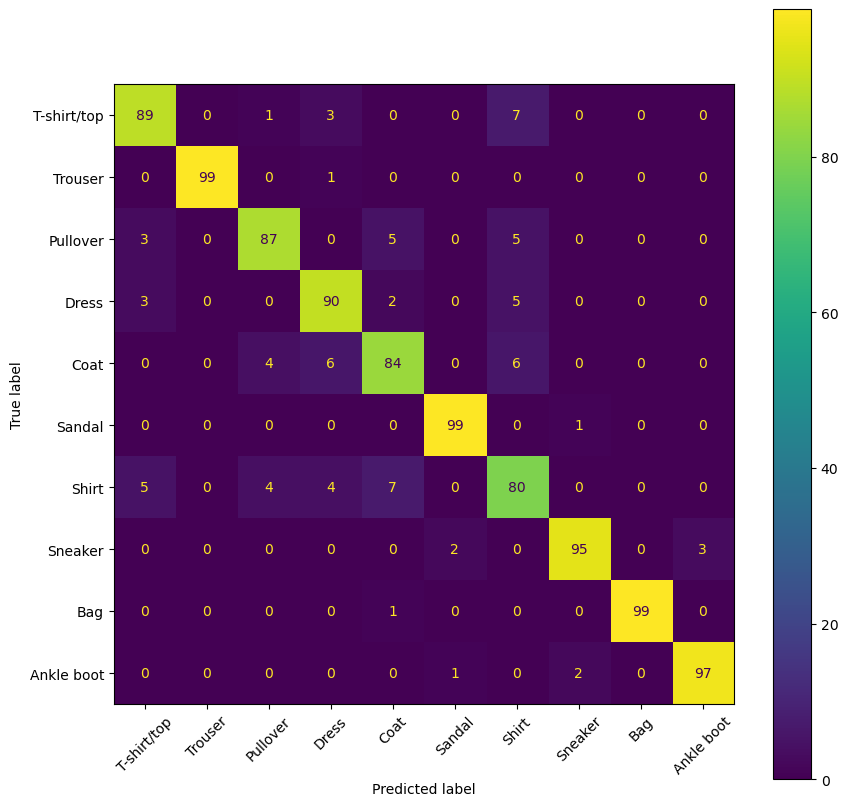

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)
_, ax = plt.subplots(figsize = (10, 10))
display.plot(xticks_rotation = 45, ax=ax)
plt.show()

In [21]:
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets

def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)

    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(chain.from_iterable(
            [target_idx[idx][ : max_len] for idx in range(len(classes))]
        ))

    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = True)
test_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(dataset = train_dataset, classes = train_dataset.classes, max_len = 1000)
subset_test_dataset = subset_sampler(dataset = test_dataset, classes = test_dataset.classes, max_len = 100)

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [22]:
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path = "microsoft/cvt-21")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        transforms.Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
    ])

In [23]:
from torch.utils.data import DataLoader

def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])

    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size = 32,
    shuffle = True,
    collate_fn = lambda x: collator(x, transform),
    drop_last = True
)

valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = lambda x: collator(x, transform),
    drop_last = True
)

In [24]:
from transformers import CvtForImageClassification

model = CvtForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21",
    num_labels = len(train_dataset.classes),
    id2label = {idx: label for label, idx in train_dataset.class_to_idx.items()}, 
    label2id = train_dataset.class_to_idx,
    ignore_mismatched_sizes = True
    )

for main_name, main_module in model.named_children():
    print(main_name)

    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)

        for ssub_name, ssub_module in sub_module.named_children() :
            print("    └", ssub_name)
            
            for sssub_name, sssub_module in ssub_module.named_children():
                print("        └", sssub_name)

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cvt
└ encoder
    └ stages
        └ 0
        └ 1
        └ 2
layernorm
classifier


In [25]:
stages= model.cvt.encoder.stages

print(stages[0])

CvtStage(
  (embedding): CvtEmbeddings(
    (convolution_embeddings): CvtConvEmbeddings(
      (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layers): Sequential(
    (0): CvtLayer(
      (attention): CvtAttention(
        (attention): CvtSelfAttention(
          (convolution_projection_query): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAttentionConvProjection(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (linear_projection): CvtSelfAttentionLinearProjection()
          )
          (convolution_projection_key): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAtte

In [26]:
batch = next(iter(train_dataloader))
print("이미지 차원: ", batch["pixel_values"].shape)

patch_emb_output = stages[0].embedding(batch["pixel_values"])
print("패치 임베딩 차원: ", patch_emb_output.shape)

batch_size, num_channels, height, width = patch_emb_output.shape
hidden_state = patch_emb_output.view(batch_size, num_channels, height * width).permute(0, 2, 1)
print("셀프 어텐션 입력 차원: ", hidden_state.shape)

attention_output = stages[0].layers[0].attention(hidden_state, height, width)
print("셀프 엍네션 출력 차원: ", attention_output.shape)

이미지 차원:  torch.Size([32, 3, 224, 224])
패치 임베딩 차원:  torch.Size([32, 64, 56, 56])
셀프 어텐션 입력 차원:  torch.Size([32, 3136, 64])
셀프 엍네션 출력 차원:  torch.Size([32, 3136, 64])


In [27]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import CvtForImageClassification
from transformers import TrainingArguments, Trainer

def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)

    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        ))

    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path = "microsoft/cvt-21",
        num_labels = len(classes),
        id2label = {idx: label for label, idx in class_to_idx.items()},
        label2id = class_to_idx,
        ignore_mismatched_sizes = True
    )

    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])

    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(predictions = predictions, references = labels, average = "macro")

    return macro_f1


train_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = True)
test_dataset = datasets.FashionMNIST(root = "datasets", download = True, train = False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(dataset = train_dataset, classes = train_dataset.classes, max_len = 1000)
subset_test_dataset = subset_sampler(dataset = test_dataset, classes = test_dataset.classes, max_len = 100)

image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path = "microsoft/cvt-21")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        transforms.Normalize(mean = image_processor.image_mean, std = image_processor.image_std)
    ]
)

args = TrainingArguments(
    output_dir = "models/CvT-FashionMNIST",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.001,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    logging_dir = "logs",
    logging_steps = 125,
    remove_unused_columns = False,
    seed = 7
)

trainer = Trainer(
    model_init = lambda x: model_init(classes, class_to_idx),
    args = args,
    train_dataset = subset_train_dataset,
    eval_dataset = subset_test_dataset,
    data_collator = lambda x: collator(x, transform),
    compute_metrics = compute_metrics,
    tokenizer = image_processor,
)
trainer.train()

c:\Users\user\anaconda3\envs\testing_torch\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in t

{'loss': 1.5205, 'grad_norm': 210.81832885742188, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.2}


 13%|█▎        | 250/1875 [02:03<13:14,  2.05it/s]

{'loss': 1.0157, 'grad_norm': 91.60320281982422, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}


 20%|██        | 375/1875 [03:05<12:03,  2.07it/s]

{'loss': 0.8332, 'grad_norm': 71.37751770019531, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.6}


 27%|██▋       | 500/1875 [04:05<11:06,  2.06it/s]

{'loss': 0.846, 'grad_norm': 115.59441375732422, 'learning_rate': 7.333333333333333e-06, 'epoch': 0.8}


 33%|███▎      | 625/1875 [05:06<10:03,  2.07it/s]

{'loss': 0.8175, 'grad_norm': 153.29408264160156, 'learning_rate': 6.666666666666667e-06, 'epoch': 1.0}



 33%|███▎      | 625/1875 [05:14<10:03,  2.07it/s]

{'eval_loss': 0.32550880312919617, 'eval_f1': 0.8922698352665014, 'eval_runtime': 7.9062, 'eval_samples_per_second': 126.483, 'eval_steps_per_second': 7.968, 'epoch': 1.0}


 40%|████      | 750/1875 [06:15<09:04,  2.07it/s]  

{'loss': 0.7442, 'grad_norm': 59.627769470214844, 'learning_rate': 6e-06, 'epoch': 1.2}


 47%|████▋     | 875/1875 [07:16<08:04,  2.06it/s]

{'loss': 0.723, 'grad_norm': 56.7312126159668, 'learning_rate': 5.333333333333334e-06, 'epoch': 1.4}


 53%|█████▎    | 1000/1875 [08:16<07:03,  2.06it/s]

{'loss': 0.7272, 'grad_norm': 18.48580551147461, 'learning_rate': 4.666666666666667e-06, 'epoch': 1.6}


 60%|██████    | 1125/1875 [09:17<06:04,  2.06it/s]

{'loss': 0.7101, 'grad_norm': 63.97568893432617, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.8}


 67%|██████▋   | 1250/1875 [10:17<05:01,  2.07it/s]

{'loss': 0.6881, 'grad_norm': 21.293968200683594, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}



 67%|██████▋   | 1250/1875 [10:25<05:01,  2.07it/s]

{'eval_loss': 0.27602118253707886, 'eval_f1': 0.9218285142201117, 'eval_runtime': 7.5308, 'eval_samples_per_second': 132.788, 'eval_steps_per_second': 8.366, 'epoch': 2.0}


 73%|███████▎  | 1375/1875 [11:26<04:02,  2.06it/s]

{'loss': 0.6606, 'grad_norm': 49.680667877197266, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.2}


 80%|████████  | 1500/1875 [12:27<03:01,  2.07it/s]

{'loss': 0.6565, 'grad_norm': 87.05001068115234, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}


 87%|████████▋ | 1625/1875 [13:27<02:01,  2.06it/s]

{'loss': 0.6551, 'grad_norm': 38.52096176147461, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.6}


 93%|█████████▎| 1750/1875 [14:28<01:00,  2.07it/s]

{'loss': 0.672, 'grad_norm': 76.81236267089844, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.8}


100%|██████████| 1875/1875 [15:28<00:00,  2.07it/s]

{'loss': 0.6718, 'grad_norm': 54.92367935180664, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 1875/1875 [15:36<00:00,  2.07it/s]

{'eval_loss': 0.2516321837902069, 'eval_f1': 0.9320645000866975, 'eval_runtime': 7.5673, 'eval_samples_per_second': 132.147, 'eval_steps_per_second': 8.325, 'epoch': 3.0}


100%|██████████| 1875/1875 [15:37<00:00,  2.00it/s]

{'train_runtime': 937.2479, 'train_samples_per_second': 32.009, 'train_steps_per_second': 2.001, 'train_loss': 0.7960986612955729, 'epoch': 3.0}


TrainOutput(global_step=1875, training_loss=0.7960986612955729, metrics={'train_runtime': 937.2479, 'train_samples_per_second': 32.009, 'train_steps_per_second': 2.001, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7960986612955729, 'epoch': 3.0})

100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


PredictionOutput(predictions=array([[ 6.6579556 , -2.0375261 , -0.46026883, ..., -1.0125827 ,
        -1.4368243 , -0.9266156 ],
       [ 4.3954206 , -1.2897198 , -0.81294924, ..., -1.2290666 ,
        -1.5349174 , -0.6520933 ],
       [ 6.5133405 , -2.4679306 ,  0.09358825, ..., -1.0467659 ,
        -1.0838958 , -0.7262879 ],
       ...,
       [-1.5020278 , -0.454062  , -0.5160025 , ...,  2.9900007 ,
         0.33844244,  5.37214   ],
       [-0.85780704, -0.11380111, -0.3910891 , ...,  2.3501866 ,
        -1.4756685 ,  7.0708175 ],
       [-0.60914207, -0.25461543, -0.5938953 , ...,  0.39213622,
        -1.1761999 ,  7.4013605 ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

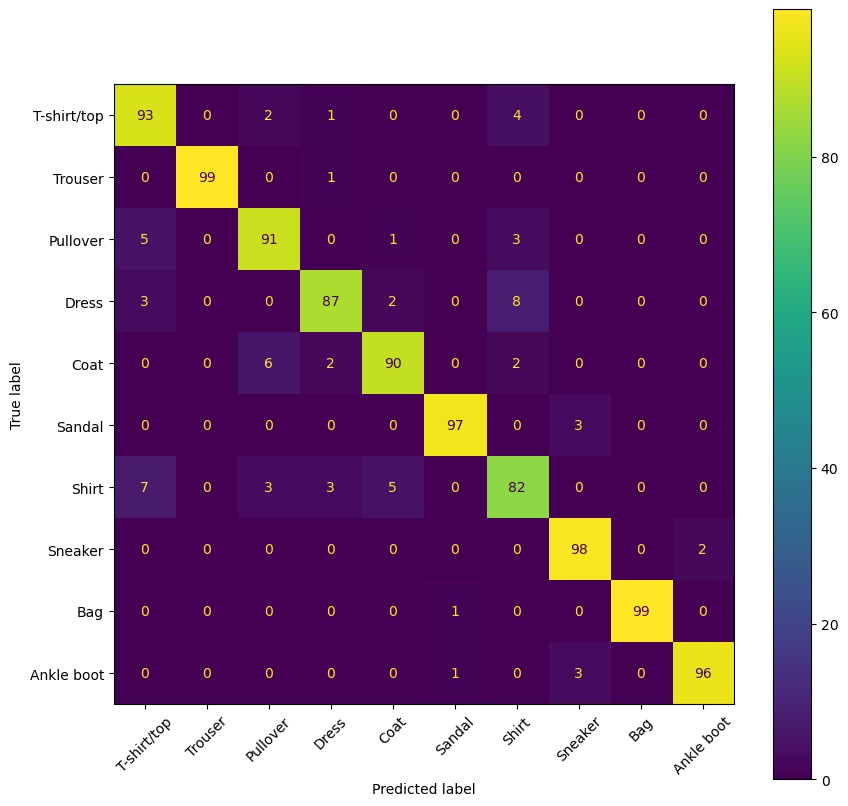

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)
_, ax = plt.subplots(figsize = (10, 10))
display.plot(xticks_rotation = 45, ax = ax)
plt.show()